In [1]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2
import numpy as np

Cifar10 veri setinin içinde bulunan resimleri vgg modeline imput olarak verirken vgg modeli 48x48 lik resimleri alırım diyor ama cifar10 veri setindeki resimler 48x48 lik değil. Bu yüzden boyutu değiştireceğiz ve bu boyutu değiştirirken de Opencv kütüphanesini kullanacağız. "import cv2" satırı ile opencv kütüphanesi import edilmiştir.

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train),(x_test, y_test) = cifar10.load_data()
print("x_train shape",x_train.shape)
print("train sample:",x_train.shape[0])

x_train shape (50000, 32, 32, 3)
train sample: 50000


Yukarıdaki kod satırı ile veri seti yüklenmiştir.

In [3]:
numberOfClass = 10

numberOfClass değişkeninde cifar veri setinde kaç tane class olduğu bilgisini depoladık. 10 farklı class yani 10 farklı resim vardır. Uçak, kedi, köpek gibi farklı resimler vardır. Bunları categorical hale getirelim.

In [4]:
y_train = to_categorical(y_train, numberOfClass)
y_test = to_categorical(y_test, numberOfClass)

Yukarıdaki kod bloğu ile y_train ve y_test'in içerisindeki her bir class categorical hale getirilmiştir.

In [5]:
x_train.shape

(50000, 32, 32, 3)

Yukarıda görüldüğü üzere x_train in shape'i 4 tane parametreden oluşan bir tuple veriyor. Bu değerlerden 32,32,3 kısmı shape'dir. Son parametreden anlaşılacağı üzere resimler rgb'dir.

In [6]:
input_shape = x_train.shape[1:]

Yukarıdaki kodun bir üstündeki kodda gördülüğü üzere 32,32,3 kısmı shape'dir. Dolayısıyla ilk parametre dahil edilmeyip sonraki parametreler input_shape değişkenine atanmıştır.

Bu rgb resimleri görselleştirelim.

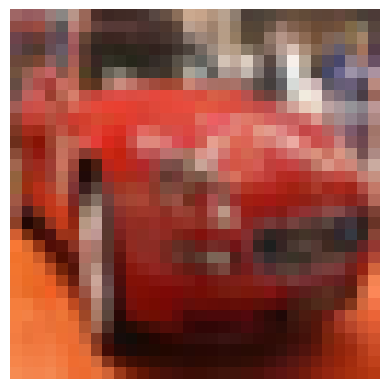

In [7]:
#%% visualize
plt.imshow(x_train[5].astype(np.uint8))
plt.axis("off")
plt.show()

5.resmin araba olduğunu output'ta görmekteyiz.

Veri setindeki resimlerin boyutu 32x32 dir. Fakat vgg19 modeli minimum 48x48 lik input'lar istemektedir. Bu yüzden vgg modeline uygun olması için veri setindeki biraz genişletmeliyiz. OpenCV kütüphanesini kullanarak 32x32'yi 48x48 yapabiliriz. Şimdi veri seti içerisinde bulunan resimlerin size'ını vgg19 modelinin istekleri doğrultusunda güncelleyelim. Yani veri setindeki resimlerin boyutlarını büyütmeliyiz.

In [8]:
#increase dimension
def resize_img(img):
    numberOfImage = img.shape[0]  #resim sayısıdır.
    new_array = np.zeros((numberOfImage, 48,48,3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i,:,:,:],(48,48))
    return new_array

Yukarıdaki kod bloğunda resimlerin her birinin boyutu 4848'e yükseltilmiştir.

img[i,:,:,:] ifadesinde, img'nin i.resmi alınmıştır ve :,:,: ifadesi resmin ile tüm boyutunun alınması sağlanmıştır. :,:,: yerine 32,32,3 de yazılabilir. Fakat bu ifadeyi farklı veri setleri üzerinde de kullanabilmemiz için biraz genel yazmamız daha doğru olur. 

new_array[i] = cv2.resize(img[i,:,:,:],(48,48)) satırı ile yapılan, opencv'nin resize metodu ile img[i,:,:,:] resmi 48,48 boyutuna dönüştürülmüştür.

"return new_array" ile 48,48 boyutundaki her bir resim return edilmiştir.

In [9]:
x_train = resize_img(x_train)
x_test = resize_img(x_test)
print("increased dim x_train: ",x_train.shape)

increased dim x_train:  (50000, 48, 48, 3)


Birde yukarıdaki işlemlerden ötürü resmin değişimine bakalım.

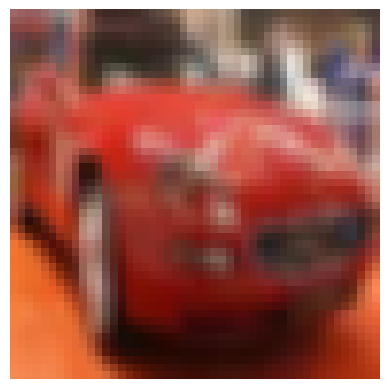

In [10]:
plt.figure()
plt.imshow(x_train[5].astype(np.uint8))
plt.axis("off")
plt.show()

Output'a bakıldığında anlaşılacağı üzere piksellerde bir artış söz konusudur.

Şimdi vgg19 modelini kullanalım.

In [11]:
#%% vgg19

vgg = VGG19(include_top = False, weights = "imagenet", input_shape = (48,48,3))

print(vgg.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

vgg = VGG19(include_top = False, weights = "imagenet", input_shape = (48,48,3)) satırını açıklayayım: 3.parametreden anlaşılacağı üzere rgb formatında 48x48 lik resimler vardır. 2.parametredeki weigths'lerin imagenet olmasının anlamı, VGG19 modeli bir transfer learning modeli olduğu için bu bir yerde eğitilmiştir ve eğitildiği yer ise imagenet veri setidir. Yani weight'ler imagenet ceri setinde eğitilmiştir. 1.parametre ise, vgg19'nin son kısımlarında fully connected layer vardır ve include_top = False ile fully connected layer'ı eklememiş oluyoruz. 

Output'u inceleyelim. Son layer MaxPooling'tir ve bu katmandan sonra normalde fully connected layer'ının olması gerekir. Yani flatten yapılması ve daha sonrada kaç tane dense layer olacaksa onların olması gerekiyor. Ama include_top = False parametresinden dolayı bu katmanlar çıkarılmıştır. Zaten vgg gibi transfer learning modellerinde genelde fully connected layer kısmını değiştiriyoruz.

Öncelikle layer'ları listeleyelim.

In [12]:
vgg_layer_list = vgg.layers
print(vgg_layer_list)

[<keras.engine.input_layer.InputLayer object at 0x000001DC96B720A0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DCA3FD2910>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DCA3FD2B80>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001DCA3FD2FA0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DCA3FD2E80>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC96D2D3D0>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001DC96D45E80>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC96D458E0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC96D45220>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC9CD74D60>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC96D4D670>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001DC9CD7AAC0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001DC9CD74D00>, <keras.layers.convolutional.conv2d

Output'ta tüm layer'ları görebilmekteyiz.

Layer'ların hepsi sequential olduğu için bu layer'ları sequential model içerisine atmamız lazım. Çünkü bunlara kendi fully connected layer'ımızı ekleyeceğiz.

In [13]:
model = Sequential()
for layer in vgg_layer_list:
    model.add(layer)
    
print(model.summary()) #Modelin içerisini görmek için.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [14]:
for layer in model.layers:
    layer.trainable = False

Şöyle bir sorun var. Sequantial model oluşturduk. Eğer bu modeli eğitirsek sadece yeni eklediğimiz fulley connected layer değil, öncesindeki tüm katmanlarda eğitilecektir. Bu durumu istemiyoruz ki transfer learning kullanma amacımız da buydu zaten. Daha önceden öğrenilmiş, transfer edilmiş bir yapı var ve biz bu yapıyı kullanmak istiyoruz. Bu yüzden kendi layer'ımızı eklemeden önce yukarıdaki kod bloğunu oluşturduk. Yukarıdaki kod bloğu ile modelin layer'larının train edilmesi engellenmiştir. 

Şimdi modele fully connected layer kısmını ekleyelim.

Bir tane flatten yapmak zorundayız. Daha sonra bir tane de dense layer ekleyelim. Sonra birde output layer ekleyelim.

In [15]:
# fully connected layers
model.add(Flatten())
model.add(Dense(128))  #128 tane nöron ekledik.
model.add(Dense(numberOfClass, activation= "softmax"))  #output layer eklenmiştir. Output layer'da Dense layer'dır.
#output layer'daki nöron sayısı class sayısı kadar olmalıdır.

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

Output'ta görüldüğü üzere Flatten layer ekledik, Dense layer ekledik, output layer ekledik.

Artık compile etme aşamasına yani training aşamasına geçebiliriz.

In [17]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [19]:
hist = model.fit(x_train, y_train, validation_split = 0.2, epochs = 5, batch_size = 1000)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Kaydettiğimiz şeyleri içerisinde tutmak için bir hist değişkeni oluşturdum.

Yukarıdaki kod bloğunu açıklayayım. train datası fit edileceğinden 1. ve 2.parametrelere train datalarını yazdık. 3.parametre ile, modeli train ederken bir validation veri seti oluşturuyor ve bu valication setini x_train ve y_train içerisinden %20'si olacak şekilde ayarlıyor.  

In [ ]:
# model save
model.save_weights("example.h5")

In [ ]:
plt.plot(hist.history["loss"], label = "train loss")
plt.plot(hist.history["val_loss"], label = "val loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history["acc"], label = "train acc")
plt.plot(hist.history["val_acc"], label = "val acc")
plt.legend()
plt.show()

In [ ]:
# load
import json, codecs
with codecs.open("transfer_learning_vgg19_cfar10.json","r",encoding = "utf-8") as f:
    n = json.loads(f.read())

plt.plot(n["acc"], label = "train acc")
plt.plot(n["val_acc"], label = "val acc")
plt.legend()
plt.show()


# save
with open('transfer_learning_vgg19_cfar10.json', 'w') as f:
    json.dump(hist.history, f)